# Poisson-Gamma model

See Mohler et al, *Reducing Bias in Estimates for the Law of Crime Concentration* J.Quantitative Criminology, 2019 https://doi.org/10.1007/s10940-019-09404-1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import gamma, nbinom

from utils import (
    CATEGORIES,
    extract_crime_data,
    get_census_boundaries,
    get_force_boundary,
    tokenize_force_name,
)

In [3]:
FORCE = "West Yorkshire"
rng = np.random.default_rng(19937)

force_boundary = get_force_boundary(FORCE)

CATEGORY = CATEGORIES[1]
crime_data = extract_crime_data(tokenize_force_name(FORCE))
# filter by catgegory and remove any points
crime_data = crime_data[(crime_data["Crime type"] == CATEGORY)]
crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry
Crime ID,,,,,,,,,,
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411354.013 447133.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411758.03 447302.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,NaN,NaN,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...,...,...
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,NaN,NaN,POINT (446750.007 410878.044)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,NaN,NaN,POINT (446414.024 410431.008)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,NaN,NaN,POINT (446666.975 410800.005)


In [6]:
# get ALL the LSOAs in the force area
lsoa_boundaries = get_census_boundaries("LSOA21", "GC", overlapping=force_boundary)
lsoa_boundaries

,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry
LSOA21CD,,,,,,,,
E01005409,Oldham 020D,None,402127,403557,53.5287,-1.96938,c07a6039-4c7e-4711-a4f1-43f133884e37,"POLYGON ((405025.033 406281.173, 405102.813 40..."
E01005410,Oldham 006A,None,402031,407499,53.5641,-1.97081,ec25b8b6-3bb2-41f4-9771-e203db1a4782,"POLYGON ((401277.5 409262.406, 401324.813 4092..."
E01005414,Oldham 006C,None,399091,410890,53.5946,-2.01521,decd0ebb-ac17-4239-bab5-0b04c1e50c3d,"POLYGON ((398471 413426.406, 398573.499 413253..."
E01005518,Rochdale 001A,None,394131,418913,53.6667,-2.09030,c0d478c0-aeba-45ea-83a4-cc9e1674772f,"POLYGON ((396713.094 420803.281, 396867.406 42..."
E01005521,Rochdale 003C,None,395569,416007,53.6406,-2.06849,f4ac1eb6-8200-4d86-af67-21981175e520,"POLYGON ((397738.5 417901.781, 397679.406 4176..."
...,...,...,...,...,...,...,...,...
E01035050,Leeds 105G,None,430214,426790,53.7366,-1.54345,4f0cba78-bfe1-4843-ab4b-bb44e691f99e,"POLYGON ((430737.415 427501.249, 430760.513 42..."
E01035051,Leeds 105H,None,431335,427174,53.7400,-1.52641,2de24ca1-ac16-44b0-a316-24ba49dba14c,"POLYGON ((431229.959 427511.255, 431264.502 42..."
E01035052,Leeds 105I,None,431014,426532,53.7343,-1.53135,1d808faa-55df-40ac-8dbd-50144f26e717,"POLYGON ((431312.508 427066, 431268.346 426814..."


In [7]:
# ensure we account for crime-free LSOAs in the data
counts = (
    crime_data.groupby(["Month", "LSOA code"])["Crime type"].count().unstack(level="Month", fill_value=0).sort_index()
)
counts = counts.reindex(lsoa_boundaries.index, fill_value=0)
counts

Month,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,...,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
LSOA21CD,,,,,,,,,,,,,,,,,,,,,
E01005409,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E01005410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E01005414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
E01005518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E01005521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E01035050,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,0,1,1,0,3,2
E01035051,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
E01035052,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,1,0,0,0,2,1


In [8]:
def nbinom_fit(sample: pd.Series):
    sample.name = "nbdata"
    # Dispersion parameter from nb model with only interaction term
    nbfit = smf.negativebinomial("nbdata ~ 1", data=sample.to_frame()).fit()
    mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
    alpha = nbfit.params[1]  # Dispersion parameter
    var = mu + alpha * mu**2
    p = mu / var
    n = mu**2 / (var - mu)
    return pd.Series({"n": n, "p": p})

In [9]:
model_params = counts.apply(nbinom_fit).T
model_params

Optimization terminated successfully.
         Current function value: 1.699714
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.808384
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.946719
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.952837
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.721547
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.725679
         Iterations: 5
         Function evaluations: 6
         Gradient e

/tmp/ipykernel_25242/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_25242/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_25242/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_25242/2054698704.

Optimization terminated successfully.
         Current function value: 1.733236
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.946309
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.875515
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.899351
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.886446
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 1.640241
         Iterations: 6
         Function evaluations: 7
         Gradient e

/tmp/ipykernel_25242/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_25242/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_25242/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_25242/2054698704.

,n,p
Month,,
2022-05,0.834137,0.351524
2022-06,0.908387,0.339842
2022-07,0.889146,0.297780
2022-08,0.887654,0.295864
2022-09,0.752483,0.321104
2022-10,0.743507,0.317188
2022-11,0.670896,0.353973
2022-12,0.535366,0.416453
2023-01,0.666856,0.405918


<Axes: xlabel='Month'>

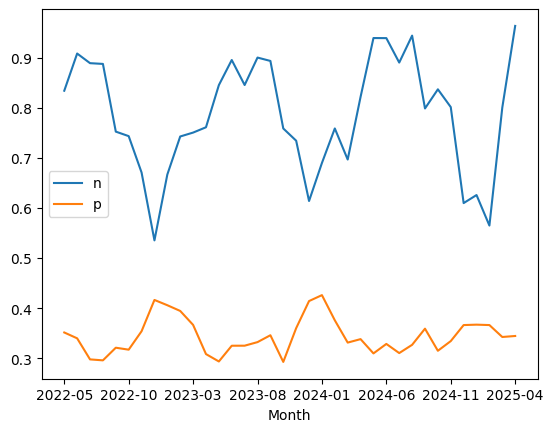

In [10]:
model_params.plot()

<Axes: xlabel='Month'>

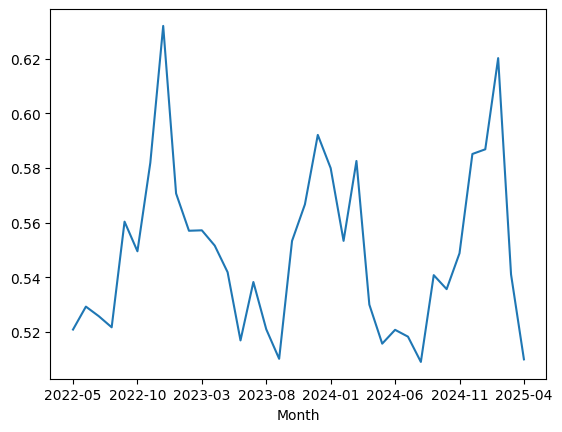

In [ ]:
# Seasonality of **crime concentration**

# translated from Appendix in Mohler (2019)
samples = len(counts)
threshold = int(0.1 * samples)


def calc_gini(model_params: pd.Series):
    # simulated_gam=rgamma(Ntotal, shape=pars[1], rate=1)
    # scipy.stats.gamma uses shape (a) and scale (1/rate)
    # descending order by virtue of sorting on a reversed *view* of the array

    # this is sampled lambda??
    gamma_sample = np.sort(gamma.rvs(a=model_params["n"], scale=1, size=samples, random_state=rng))[::-1]

    # but the mean of Poisson(lamdba) == lambda, so we can use

    # concentration=sum(sorted_gam[1:Nflag])/sum(sorted_gam)
    # Python slicing is 0-based and exclusive of the end index.
    # R's 1:Nflag corresponds to indices 0 to Nflag-1 in Python, which is [:Nflag]
    _concentration = np.sum(gamma_sample[:threshold]) / np.sum(gamma_sample)
    # print(f"Concentration (simulated): {concentration:.4f}")
    # # normalized_gam=sorted_gam/sum(sorted_gam)
    gamma_norm = gamma_sample / np.sum(gamma_sample)

    # # gini=(1/Ntotal)*(2*sum(cumsum(normalized_gam))-Ntotal-1)
    gini = (1.0 / samples) * (2 * np.sum(np.cumsum(gamma_norm)) - samples - 1)
    return gini


gini = model_params.apply(calc_gini, axis=1)
gini.name = "gini"
gini.plot()

In [12]:
# sample and compare fits
n = model_params.n.mean()
p = model_params.p.mean()
sample = pd.Series(nbinom(n, p).rvs(size=100000, random_state=rng))

(nbinom_fit(sample) / np.array([n, p]) - 1.0).rename("diff")

Optimization terminated successfully.
         Current function value: 1.671669
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


/tmp/ipykernel_25242/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_25242/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter


n    0.010247
p    0.011431
Name: diff, dtype: float64

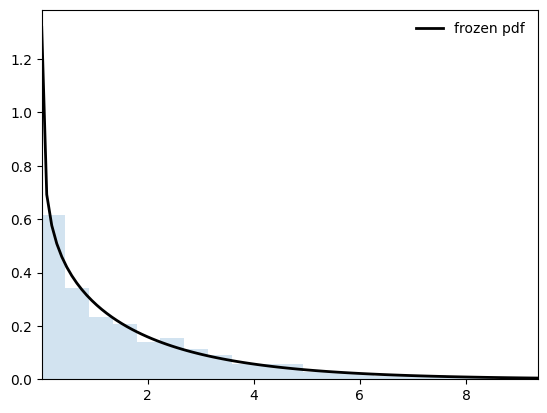

In [13]:
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

t = 1  # ? not sure about this
beta = n * t / p

_, ax = plt.subplots()
dist = gamma(a=n, scale=beta)  # or might be 1 / beta?

x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
ax.plot(x, dist.pdf(x), "k-", lw=2, label="frozen pdf")

# Check accuracy of cdf and ppf:
vals = dist.ppf([0.001, 0.5, 0.999])
np.allclose([0.001, 0.5, 0.999], dist.cdf(vals))

# Generate random numbers:
r = dist.rvs(size=1000, random_state=rng)

# And compare the histogram:
ax.hist(r, density=True, bins="auto", histtype="stepfilled", alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc="best", frameon=False)
plt.show()

In [14]:
# sample the lambdas for each area
lambda_ = dist.rvs(size=len(counts), random_state=rng)

sim = pd.Series(rng.poisson(lambda_))
# re-fit negative binomial - why is p consistently underestimated???
nbinom_fit(sim), n, p

Optimization terminated successfully.
         Current function value: 1.824146
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


/tmp/ipykernel_25242/2054698704.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_25242/2054698704.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter


(n    0.841534
 p    0.318132
 dtype: float64,
 np.float64(0.7864611086383289),
 np.float64(0.34446572599154146))

In [93]:
sim = counts.copy()
n_areas = len(sim)
t = 1  # ? not sure about this

for col in sim:
    n, p = model_params.loc[col]
    beta = n * t / p
    lambda_ = gamma.rvs(a=n, scale=beta, size=n_areas)
    sim[col] = rng.poisson(lambda_)

# forcing scale to around 1.95 lines these up
counts.mean().mean(), sim.mean().mean()

(np.float64(1.539197742698086), np.float64(1.8931403950278347))

In [91]:
counts.sum().sum(), sim.sum().sum()

(np.int64(80734), np.int64(97949))